<a href="https://colab.research.google.com/github/AnkurMali/IST597_Spring_2022/blob/main/IST597_MLP_collab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IST597:- Multi-Layer Perceptron

## Load the libraries

In [1]:
import os
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score
import keras
import time
import math
import tensorflow as tf
import torch.nn as nn
from keras.datasets import fashion_mnist

seed=97238684
np.random.seed(seed)
tf.random.set_seed(seed)
# np.random.seed(1234)
# tf.random.set_seed(1234)
from sklearn.model_selection import train_test_split

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

#Get number of Gpu's and id's in the system or else you can also use Nvidia-smi in command prompt.

## Generate random data

In [3]:
size_input = 784
size_hidden1 = 512
size_hidden2 = 256
size_hidden3 = 128
size_output = 10
starter_learning_rate = 0.001
regularizer_rate = 0.1

#MNIST Data Load

In [4]:
train_ratio = 0.80
validation_ratio = 0.10
test_ratio = 0.10

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X = np.concatenate([X_train, X_test])
y = np.concatenate([y_train, y_test])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=(1-train_ratio))
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=((test_ratio/(validation_ratio+test_ratio))))

X_train.shape


11501568/11490434 [==============================] - 0s 0us/step


(56000, 28, 28)

#Fashion MNIST Data Load

In [5]:
(Xtrain_fmnist, ytrain_fmnist), (Xtest_fmnist, ytest_fmnist) = fashion_mnist.load_data()
X_fmnist = np.concatenate([Xtrain_fmnist, Xtest_fmnist])
y_fmnist = np.concatenate([ytrain_fmnist, ytest_fmnist])

Xtrain_fmnist, X_val_fmnist, ytrain_fmnist, y_val_fmnist = train_test_split(X_fmnist, y_fmnist, test_size=(1-train_ratio))
X_val_fmnist, Xtest_fmnist, y_val_fmnist, ytest_fmnist = train_test_split(X_val_fmnist, y_val_fmnist, test_size=((test_ratio/(validation_ratio+test_ratio))))

4431872/4422102 [==============================] - 0s 0us/step


#Reshape and Normalize MNIST dataset

In [6]:
X_train = np.reshape(X_train, (56000, 784))
X_test = np.reshape(X_test, (-1, 784))
X_train = X_train.astype(float) / 255
X_test = X_test.astype(float) / 255
X_val = np.reshape(X_val, (7000,784))
X_val=X_val/255.0
X_val=tf.cast(X_val,dtype=tf.float32)
y_train = tf.one_hot(y_train,10)
y_test = tf.one_hot(y_test,10)

#Reshape and Normalize Fashion MNIST dataset

In [7]:
Xtrain_fmnist = np.reshape(X_train, (56000, 784))
Xtest_fmnist = np.reshape(X_test, (-1, 784))
Xtrain_fmnist = Xtrain_fmnist.astype(float) / 255
Xtest_fmnist = Xtest_fmnist.astype(float) / 255
X_val_fmnist = np.reshape(X_val_fmnist, (7000,784))
X_val_fmnist=X_val_fmnist.astype(float) /255.0
ytrain_fmnist = tf.one_hot(ytrain_fmnist,10)
ytest_fmnist = tf.one_hot(ytest_fmnist,10)

In [8]:
print(X_train.shape, y_train.shape)
print(Xtrain_fmnist.shape, ytrain_fmnist.shape)

(56000, 784) (56000, 10)
(56000, 784) (56000, 10)


In [9]:
# Split dataset into batches
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(16)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(4)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(2)

In [10]:
# Split FMNIST dataset into batches
train_ds_fmnist = tf.data.Dataset.from_tensor_slices((Xtrain_fmnist, ytrain_fmnist)).batch(16)
test_ds_fmnist = tf.data.Dataset.from_tensor_slices((Xtest_fmnist, ytest_fmnist)).batch(4)
val_ds_fmnist = tf.data.Dataset.from_tensor_slices((X_val_fmnist, y_val_fmnist)).batch(2)

In [11]:
print("y_train: ",y_train)
print("y_val: ",y_val)
print("y_test: ",y_test)

y_train:  tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]], shape=(56000, 10), dtype=float32)
y_val:  [4 2 6 ... 6 2 5]
y_test:  tf.Tensor(
[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]], shape=(7000, 10), dtype=float32)


## Build MLP using Eager Execution With DropOut 


In [12]:
# Define class to build mlp model
class MLP(object):
  def __init__(self, size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden1, self.size_hidden2, self.size_hidden3, self.size_output, self.device =\
    size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device
    
    # Initialize weights between input layer and hidden layer
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden1]))
    self.W_h1 = tf.Variable(tf.random.normal([self.size_hidden1, self.size_hidden2]))
    # Initialize biases for hidden layer
    self.b1 = tf.Variable(tf.random.normal([1, self.size_hidden1]))
     # Initialize weights between hidden layer and output layer
    self.W_h2 = tf.Variable(tf.random.normal([self.size_hidden2, self.size_hidden3]))
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden3, self.size_output]))
    # Initialize biases for output layer
    self.b2 = tf.Variable(tf.random.normal([1, self.size_hidden2]))
    self.b3 = tf.Variable(tf.random.normal([1, self.size_hidden3]))
    self.b4 = tf.Variable(tf.random.normal([1, self.size_output]))
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W_h1, self.W_h2, self.W2, self.b1, self.b2, self.b3, self.b4]
    
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    # loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred,labels=y_true)) \
    #     + regularizer_rate*(tf.reduce_sum(tf.square(self.b1)) + tf.reduce_sum(tf.square(self.b2)) + \
    #                         tf.reduce_sum(tf.square(self.b3)) + tf.reduce_sum(tf.square(self.b4)) + \
    #                         tf.nn.l2_loss(self.W1) + tf.nn.l2_loss(self.W_h1) + tf.nn.l2_loss(self.W_h2) + tf.nn.l2_loss(self.W2) )
    return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred,labels=y_true))
    # return loss
  
  def backward(self, X_train, y_train):
    """
    backward pass
    """
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4)
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      current_loss = self.loss(predicted, y_train)
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))
        
        
  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    # Compute values in hidden layer
    what_i = tf.matmul(X_tf, self.W1) + self.b1
    hhat_i = tf.nn.relu(what_i)
    drop_out = tf.nn.dropout(hhat_i, 0.2)
    what_h1 = tf.matmul(drop_out, self.W_h1) + self.b2
    hhat_h1 = tf.nn.relu(what_h1)
    drop_out1 = tf.nn.dropout(hhat_h1, 0.2)
    what_h2 = tf.matmul(drop_out1, self.W_h2) + self.b3
    hhat_h2 = tf.nn.relu(what_h2)
    drop_out2 = tf.nn.dropout(hhat_h2, 0.2)


    output = tf.matmul(drop_out2, self.W2) + self.b4
    output = tf.nn.softmax(output)
   
    return output

    # Calculate standard error
  def stderr(self,y_pred):
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    std_dev = np.std(y_pred_tf) #Calculates standard deviation
    std_err = std_dev/sqrt(len(y_pred_tf))
    return std_err 

 # Calculate variance error
  def var(self,y_pred):
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    std_dev = np.std(y_pred_tf) #Calculates standard deviation
    variance = (std_dev**2) # calculate variance
    return variance 

  def cat_accuracy(self, y_pred,y_true):
    return tf.cast(tf.equal(tf.argmax(y_true, axis=-1),tf.argmax(y_pred, axis=-1)),tf.keras.backend.floatx())


## Train Model

In [13]:
# Set number of epochs
NUM_EPOCHS = 10

In [14]:
# Initialize model using CPU MNIST Data

mlp_on_cpu = MLP(size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device='cpu')

time_start = time.time()
acc_mnist=[]
for epoch in range(NUM_EPOCHS):
  loss_total = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  accuracy=0
  train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(seed)).batch(20)
  for inputs, outputs in train_ds:
    preds = mlp_on_cpu.forward(inputs)
    loss_total = loss_total + mlp_on_cpu.loss(preds, outputs)
    lt = lt + mlp_on_cpu.loss(preds, outputs)
    mlp_on_cpu.backward(inputs, outputs)
    accuracy=mlp_on_cpu.cat_accuracy(preds, outputs)
  acc_mnist.append(np.sum(loss_total) / X_train.shape[0])
  print('Number of Epoch = {} - Average Cross Entropy:= {}, Accuracy:= {}'.format(epoch + 1, np.sum(loss_total) / X_train.shape[0], (100-(np.abs(np.sum(np.abs(accuracy)))/accuracy.shape[0]))))
time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
#For per epoch_time = Total_Time / Number_of_epochs

Number of Epoch = 1 - Average Cross Entropy:= 0.11848653738839286, Accuracy:= 99.75
Number of Epoch = 2 - Average Cross Entropy:= 0.11828339494977679, Accuracy:= 99.85
Number of Epoch = 3 - Average Cross Entropy:= 0.11828267124720983, Accuracy:= 99.95
Number of Epoch = 4 - Average Cross Entropy:= 0.11840117536272321, Accuracy:= 99.95
Number of Epoch = 5 - Average Cross Entropy:= 0.11823447963169643, Accuracy:= 99.75
Number of Epoch = 6 - Average Cross Entropy:= 0.11825023542131696, Accuracy:= 99.75
Number of Epoch = 7 - Average Cross Entropy:= 0.11828224400111607, Accuracy:= 99.8
Number of Epoch = 8 - Average Cross Entropy:= 0.11814290073939732, Accuracy:= 100.0
Number of Epoch = 9 - Average Cross Entropy:= 0.11808415004185267, Accuracy:= 99.9
Number of Epoch = 10 - Average Cross Entropy:= 0.1180231672014509, Accuracy:= 99.85

Total time taken (in seconds): 1275.76


In [15]:
# Initialize model using GPU MNIST Data With Dropout
mlp_on_gpu = MLP(size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device='gpu')
print("Model using GPU MNIST Data With Dropout")
acc_mnist_gpu=[]
time_start = time.time()
accuracy_mnist_gpu=0
for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(seed)).batch(20)
  for inputs, outputs in train_ds:
    preds = mlp_on_gpu.forward(inputs)
    loss_total_gpu = loss_total_gpu + mlp_on_gpu.loss(preds, outputs)
    lt = lt + mlp_on_gpu.loss(preds, outputs)
    mlp_on_gpu.backward(inputs, outputs)
    accuracy_mnist_gpu=mlp_on_cpu.cat_accuracy(preds, outputs)
  acc_mnist_gpu.append(np.sum(loss_total) / X_train.shape[0])
  print('Number of Epoch = {} - Average Cross Entropy:= {}, Accuracy:= {}'.format(epoch + 1, np.sum(loss_total_gpu) / X_train.shape[0], (100-(np.abs(np.sum(np.abs(accuracy_mnist_gpu)))/accuracy_mnist_gpu.shape[0]))))
time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))

Model using GPU MNIST Data With Dropout
Number of Epoch = 1 - Average Cross Entropy:= 0.11942680140904018, Accuracy:= 100.0
Number of Epoch = 2 - Average Cross Entropy:= 0.11934793526785714, Accuracy:= 99.95
Number of Epoch = 3 - Average Cross Entropy:= 0.11938520159040178, Accuracy:= 99.9
Number of Epoch = 4 - Average Cross Entropy:= 0.119300048828125, Accuracy:= 99.95
Number of Epoch = 5 - Average Cross Entropy:= 0.11933566720145089, Accuracy:= 99.9
Number of Epoch = 6 - Average Cross Entropy:= 0.11927894810267857, Accuracy:= 100.0
Number of Epoch = 7 - Average Cross Entropy:= 0.11928321184430804, Accuracy:= 99.9
Number of Epoch = 8 - Average Cross Entropy:= 0.11937851388113839, Accuracy:= 100.0
Number of Epoch = 9 - Average Cross Entropy:= 0.11933047049386161, Accuracy:= 99.7
Number of Epoch = 10 - Average Cross Entropy:= 0.11924797712053571, Accuracy:= 99.95

Total time taken (in seconds): 806.91


In [16]:
#Default mode MNIST Data with dropout
mlp_on_default = MLP(size_input, size_hidden1, size_hidden2, size_hidden3, size_output)

print("Default Model MNIST Data With Dropout")
acc_mnist_default=[]
time_start = time.time()
accuracy_mnist_default=0
for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(1234)).batch(20)
  for inputs, outputs in train_ds:
    preds = mlp_on_default.forward(inputs)
    loss_total_gpu = loss_total_gpu + mlp_on_default.loss(preds, outputs)
    lt = lt + mlp_on_default.loss(preds, outputs)
    mlp_on_default.backward(inputs, outputs)
    accuracy_mnist_default=mlp_on_cpu.cat_accuracy(preds, outputs)
  acc_mnist_default.append(np.sum(loss_total) / X_train.shape[0])
  print('Number of Epoch = {} - Average Cross Entropy:= {}, Accuracy:= {}'.format(epoch + 1, np.sum(loss_total_gpu) / X_train.shape[0], (100-(np.abs(np.sum(np.abs(accuracy_mnist_default)))/accuracy_mnist_default.shape[0]))))
time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))

Default Model MNIST Data With Dropout
Number of Epoch = 1 - Average Cross Entropy:= 0.11848095703125, Accuracy:= 99.8
Number of Epoch = 2 - Average Cross Entropy:= 0.11849999128069197, Accuracy:= 99.85
Number of Epoch = 3 - Average Cross Entropy:= 0.11855079868861607, Accuracy:= 99.8
Number of Epoch = 4 - Average Cross Entropy:= 0.11852580915178572, Accuracy:= 99.85
Number of Epoch = 5 - Average Cross Entropy:= 0.1185147705078125, Accuracy:= 99.95
Number of Epoch = 6 - Average Cross Entropy:= 0.11839197649274553, Accuracy:= 99.8
Number of Epoch = 7 - Average Cross Entropy:= 0.11842915562220982, Accuracy:= 99.85
Number of Epoch = 8 - Average Cross Entropy:= 0.11841799490792411, Accuracy:= 100.0
Number of Epoch = 9 - Average Cross Entropy:= 0.11828645542689732, Accuracy:= 99.8
Number of Epoch = 10 - Average Cross Entropy:= 0.11834884207589286, Accuracy:= 100.0

Total time taken (in seconds): 802.02


In [17]:
#TPU mode on MNIST data with dropout
mlp_on_gpu = MLP(size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device='tpu')

print("TPU Model MNIST Data With Dropout")
acc_mnist_tpu=[]
time_start = time.time()
accuracy_mnist_tpu=0
for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(1234)).batch(20)
  for inputs, outputs in train_ds:
    preds = mlp_on_gpu.forward(inputs)
    loss_total_gpu = loss_total_gpu + mlp_on_gpu.loss(preds, outputs)
    lt = lt + mlp_on_gpu.loss(preds, outputs)
    mlp_on_gpu.backward(inputs, outputs)
    accuracy_mnist_tpu=mlp_on_cpu.cat_accuracy(preds, outputs)
  acc_mnist_tpu.append(np.sum(loss_total) / X_train.shape[0])
  print('Number of Epoch = {} - Average Cross Entropy:= {}, Accuracy:= {}'.format(epoch + 1, np.sum(loss_total_gpu) / X_train.shape[0], (100-(np.abs(np.sum(np.abs(accuracy_mnist_tpu)))/accuracy_mnist_tpu.shape[0]))))
time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))

TPU Model MNIST Data With Dropout
Number of Epoch = 1 - Average Cross Entropy:= 0.11799689592633929, Accuracy:= 99.75
Number of Epoch = 2 - Average Cross Entropy:= 0.11807221330915178, Accuracy:= 100.0
Number of Epoch = 3 - Average Cross Entropy:= 0.11808798653738839, Accuracy:= 99.85
Number of Epoch = 4 - Average Cross Entropy:= 0.11793612234933036, Accuracy:= 99.9
Number of Epoch = 5 - Average Cross Entropy:= 0.11808175223214286, Accuracy:= 99.8
Number of Epoch = 6 - Average Cross Entropy:= 0.11803339494977678, Accuracy:= 100.0
Number of Epoch = 7 - Average Cross Entropy:= 0.11803739711216518, Accuracy:= 99.85
Number of Epoch = 8 - Average Cross Entropy:= 0.11799311174665178, Accuracy:= 99.9
Number of Epoch = 9 - Average Cross Entropy:= 0.11786569649832589, Accuracy:= 99.95
Number of Epoch = 10 - Average Cross Entropy:= 0.11793460518973214, Accuracy:= 99.85

Total time taken (in seconds): 1249.62


In [19]:
# Initialize model using CPU FMNIST Data
print("model using CPU FMNIST Data With dropout")
mlp_on_cpu = MLP(size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device='cpu')

time_start = time.time()
acc_fmnist_cpu=[]
for epoch in range(NUM_EPOCHS):
  loss_total_fmnist = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  accuracy_fmnist_cpu =0
  train_ds_fmnist = tf.data.Dataset.from_tensor_slices((Xtrain_fmnist, ytrain_fmnist)).shuffle(25, seed=epoch*(seed)).batch(20)
  for inputs, outputs in train_ds_fmnist:
    preds = mlp_on_cpu.forward(inputs)
    loss_total_fmnist = loss_total_fmnist + mlp_on_cpu.loss(preds, outputs)
    lt = lt + mlp_on_cpu.loss(preds, outputs)
    mlp_on_cpu.backward(inputs, outputs)
    accuracy_fmnist_cpu=mlp_on_cpu.cat_accuracy(preds, outputs)
  acc_fmnist_cpu.append(np.sum(loss_total_fmnist) / X_train.shape[0])
  print('Number of Epoch = {} - Average Cross Entropy:= {}, Accuracy:= {}'.format(epoch + 1, np.sum(loss_total) / X_train.shape[0], (100-(np.abs(np.sum(np.abs(accuracy_fmnist_cpu)))/accuracy_fmnist_cpu.shape[0]))))
time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
#For per epoch_time = Total_Time / Number_of_epochs

model using CPU FMNIST Data With dropout
Number of Epoch = 1 - Average Cross Entropy:= 0.1180231672014509, Accuracy:= 99.85
Number of Epoch = 2 - Average Cross Entropy:= 0.1180231672014509, Accuracy:= 99.95
Number of Epoch = 3 - Average Cross Entropy:= 0.1180231672014509, Accuracy:= 100.0
Number of Epoch = 4 - Average Cross Entropy:= 0.1180231672014509, Accuracy:= 99.95
Number of Epoch = 5 - Average Cross Entropy:= 0.1180231672014509, Accuracy:= 99.85
Number of Epoch = 6 - Average Cross Entropy:= 0.1180231672014509, Accuracy:= 99.9
Number of Epoch = 7 - Average Cross Entropy:= 0.1180231672014509, Accuracy:= 99.95
Number of Epoch = 8 - Average Cross Entropy:= 0.1180231672014509, Accuracy:= 99.9
Number of Epoch = 9 - Average Cross Entropy:= 0.1180231672014509, Accuracy:= 99.85
Number of Epoch = 10 - Average Cross Entropy:= 0.1180231672014509, Accuracy:= 100.0

Total time taken (in seconds): 1174.03


In [20]:
# Initialize model using GPU FMNIST Data with dropout
mlp_on_gpu = MLP(size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device='gpu')
print("model using GPU FMNIST Data with dropout")
time_start = time.time()
acc_fmnist_gpu=[]
for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  accuracy_fmnist_gpu=0
  train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(seed)).batch(20)
  for inputs, outputs in train_ds_fmnist:
    preds = mlp_on_gpu.forward(inputs)
    loss_total_gpu = loss_total_gpu + mlp_on_gpu.loss(preds, outputs)
    lt = lt + mlp_on_gpu.loss(preds, outputs)
    mlp_on_gpu.backward(inputs, outputs)
    accuracy_fmnist_gpu=mlp_on_cpu.cat_accuracy(preds, outputs)
  acc_fmnist_gpu.append(np.sum(loss_total) / Xtrain_fmnist.shape[0])
  print('Number of Epoch = {} - Average Cross Entropy:= {}, Accuracy:= {}'.format(epoch + 1, np.sum(loss_total_gpu) / Xtrain_fmnist.shape[0], (100-(np.abs(np.sum(np.abs(accuracy_fmnist_gpu)))/accuracy_fmnist_gpu.shape[0]))))
time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))

model using GPU FMNIST Data with dropout
Number of Epoch = 1 - Average Cross Entropy:= 0.11802091761997768, Accuracy:= 99.9
Number of Epoch = 2 - Average Cross Entropy:= 0.11804613385881696, Accuracy:= 99.8
Number of Epoch = 3 - Average Cross Entropy:= 0.1180953369140625, Accuracy:= 99.9
Number of Epoch = 4 - Average Cross Entropy:= 0.11808328683035714, Accuracy:= 99.85
Number of Epoch = 5 - Average Cross Entropy:= 0.11805632672991072, Accuracy:= 99.9
Number of Epoch = 6 - Average Cross Entropy:= 0.1181622314453125, Accuracy:= 99.8
Number of Epoch = 7 - Average Cross Entropy:= 0.11799068777901786, Accuracy:= 99.85
Number of Epoch = 8 - Average Cross Entropy:= 0.11809321812220983, Accuracy:= 100.0
Number of Epoch = 9 - Average Cross Entropy:= 0.11811969866071428, Accuracy:= 100.0
Number of Epoch = 10 - Average Cross Entropy:= 0.11793426513671874, Accuracy:= 99.7

Total time taken (in seconds): 823.04


In [22]:
#TPU mode FMNIST Data with dropout

mlp_on_gpu = MLP(size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device='tpu')
acc_fmnist_tpu=[]
time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  accuracy_fmnist_tpu=0
  train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(1234)).batch(20)
  for inputs, outputs in train_ds:
    preds = mlp_on_gpu.forward(inputs)
    loss_total_gpu = loss_total_gpu + mlp_on_gpu.loss(preds, outputs)
    lt = lt + mlp_on_gpu.loss(preds, outputs)
    mlp_on_gpu.backward(inputs, outputs)
    accuracy_fmnist_tpu = mlp_on_gpu.cat_accuracy(preds, outputs)
  acc_fmnist_tpu.append(np.sum(loss_total_gpu) / X_train.shape[0])
  print('Number of Epoch = {} - Average MSE:= {}, accuracy:={}'.format(epoch + 1, np.sum(loss_total_gpu) / X_train.shape[0], (100-(np.abs(np.sum(np.abs(accuracy_fmnist_tpu)))/accuracy_fmnist_tpu.shape[0]))))
time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))

Number of Epoch = 1 - Average MSE:= 0.117827880859375, accuracy:=99.9
Number of Epoch = 2 - Average MSE:= 0.11776003592354911, accuracy:=99.9
Number of Epoch = 3 - Average MSE:= 0.11774168178013393, accuracy:=99.9
Number of Epoch = 4 - Average MSE:= 0.1177215576171875, accuracy:=99.9
Number of Epoch = 5 - Average MSE:= 0.11780984933035714, accuracy:=99.8
Number of Epoch = 6 - Average MSE:= 0.11777385602678571, accuracy:=99.9
Number of Epoch = 7 - Average MSE:= 0.11761566162109376, accuracy:=99.8
Number of Epoch = 8 - Average MSE:= 0.11766147286551339, accuracy:=99.85
Number of Epoch = 9 - Average MSE:= 0.11768771798270089, accuracy:=99.75
Number of Epoch = 10 - Average MSE:= 0.11753141566685268, accuracy:=99.85

Total time taken (in seconds): 1229.29


## One Step Inference

In [21]:
test_loss_total = tf.Variable(0, dtype=tf.float32)
#test_loss_total = 0.0
for inputs, outputs in test_ds:
  preds = mlp_on_cpu.forward(inputs)
  #b = mlp_on_default.loss(preds, outputs)
  test_loss_total = test_loss_total + mlp_on_cpu.loss(preds, outputs)
# a = (test_loss_total.numpy() / X_train.shape[0])
# print(X_train.shape[0])
# print(test_loss_total.numpy())
# print(b)
print('Test MSE: {:.4f}'.format(np.sum(test_loss_total.numpy()) / X_train.shape[0]))

Test MSE: 0.0745


In [24]:
test_loss_total = tf.Variable(0, dtype=tf.float32)
#test_loss_total = 0.0
accuracy=0
for inputs, outputs in train_ds_fmnist:
  preds = mlp_on_cpu.forward(inputs)
  #b = mlp_on_default.loss(preds, outputs)
  test_loss_total = test_loss_total + mlp_on_cpu.loss(preds, outputs)
  accuracy=mlp_on_cpu.cat_accuracy(preds, outputs)
# a = (test_loss_total.numpy() / X_train.shape[0])
# print(X_train.shape[0])
# print(test_loss_total.numpy())
# print(b)
print("For MNIST inference\n")
print('Test categorical_cross_entropy: {:.4f}- Accuracy:={}'.format(np.sum(test_loss_total.numpy()) / X_train.shape[0],(100-(np.abs(np.sum(np.abs(accuracy)))/accuracy.shape[0]))))

For MNIST inference

Test categorical_cross_entropy: 0.1181- Accuracy:=99.95


In [25]:
test_loss_total = tf.Variable(0, dtype=tf.float32)
#test_loss_total = 0.0
accuracy=0
for inputs, outputs in test_ds_fmnist:
  preds = mlp_on_cpu.forward(inputs)
  #b = mlp_on_default.loss(preds, outputs)
  test_loss_total = test_loss_total + mlp_on_cpu.loss(preds, outputs)
  accuracy=mlp_on_cpu.cat_accuracy(preds, outputs)
# a = (test_loss_total.numpy() / X_train.shape[0])
# print(X_train.shape[0])
# print(test_loss_total.numpy())
# print(b)
print("For FMNIST testing data inference\n")
print('Test categorical_cross_entropy: {:.4f}- Accuracy:={}'.format(np.sum(test_loss_total.numpy()) / Xtest_fmnist.shape[0],(100-(np.abs(np.sum(np.abs(accuracy)))/accuracy.shape[0]))))

For FMNIST testing data inference

Test categorical_cross_entropy: 0.5903- Accuracy:=100.0


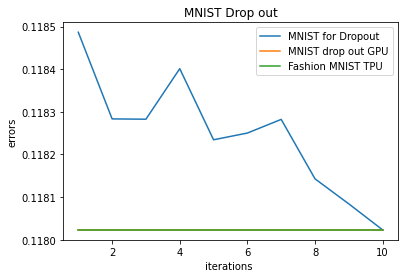

In [18]:
# Plot learning curve (with errors)
import matplotlib.pyplot as plt
%matplotlib inline
iterations = [1,2,3,4,5,6,7,8,9,10]
errors = np.squeeze(acc_mnist)
errors_gpu = np.squeeze(acc_mnist_gpu)
errors_tpu = np.squeeze(acc_mnist_tpu)
errors_default = np.squeeze(acc_mnist_default)
plt.plot(iterations,errors,label='MNIST for Dropout')
plt.plot(iterations,errors_gpu,label='MNIST drop out GPU')
plt.plot(iterations,errors_tpu,label='Fashion MNIST TPU')
plt.ylabel('errors')
plt.xlabel('iterations ')
plt.title("MNIST Drop out")
plt.legend()
plt.show()

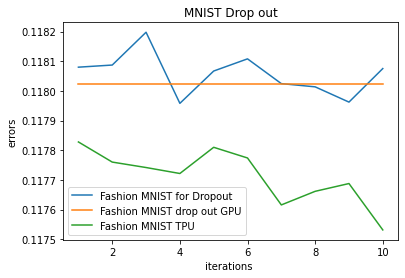

In [26]:
# Plot learning curve (with errors)
import matplotlib.pyplot as plt
%matplotlib inline
iterations = [1,2,3,4,5,6,7,8,9,10]
errors = np.squeeze(acc_fmnist_cpu)
errors_gpu = np.squeeze(acc_fmnist_gpu)
errors_tpu = np.squeeze(acc_fmnist_tpu)
# errors_default = np.squeeze(acc_fmnist_default)
plt.plot(iterations,errors,label='Fashion MNIST for Dropout')
plt.plot(iterations,errors_gpu,label='Fashion MNIST drop out GPU')
plt.plot(iterations,errors_tpu,label='Fashion MNIST TPU')
plt.ylabel('errors')
plt.xlabel('iterations ')
plt.title("MNIST Drop out")
plt.legend()
plt.show()

In [25]:
from numpy import sqrt
test_loss_total = tf.Variable(0, dtype=tf.float32)
acc_preds = tf.Variable(0,dtype=tf.float32)
#test_loss_total = 0.0
for inputs, outputs in test_ds_fmnist:
  preds = mlp_on_cpu.forward(inputs)
  # print(preds)
  b = mlp_on_cpu.loss(preds, outputs)
  standard_error = mlp_on_cpu.stderr(preds) # Standard error
  # print(b)
  test_loss_total = test_loss_total + mlp_on_cpu.loss(preds, outputs)
# a = (test_loss_total.numpy() / X_train.shape[0])
# print(X_train.shape[0])
  Variance = mlp_on_cpu.var(preds) # Variance

  for i in range(preds.shape[0]):
    if tf.argmax(preds[i])==tf.argmax(outputs[i]):
      acc_preds = acc_preds + 1.0
acc = (acc_preds/Xtest_fmnist.shape[0])*100.0
print('Inference 1st')
print('Test MSE: {:.4f}'.format(np.sum(test_loss_total.numpy())/Xtest_fmnist.shape[0]))
print('Accuracy: {:.4f}'.format(acc))
print('Standard Error: {:.4f}'.format(standard_error))
print('Variance: {:.4f}'.format(Variance))

print('Test MSE: {:.4f}'.format(np.sum(test_loss_total.numpy()) / Xtest_fmnist.shape[0]))

Inference 1st
Test MSE: 0.5909
Accuracy: 9.7429
Standard Error: 0.1500
Variance: 0.0900
Test MSE: 0.5909


In [24]:
from numpy import sqrt
test_loss_total = tf.Variable(0, dtype=tf.float32)
acc_preds = tf.Variable(0,dtype=tf.float32)
#test_loss_total = 0.0
for inputs, outputs in test_ds:
  preds = mlp_on_cpu.forward(inputs)
  # print(preds)
  b = mlp_on_cpu.loss(preds, outputs)
  standard_error = mlp_on_cpu.stderr(preds) # Standard error
  # print(b)
  test_loss_total = test_loss_total + mlp_on_cpu.loss(preds, outputs)
# a = (test_loss_total.numpy() / X_train.shape[0])
# print(X_train.shape[0])
  Variance = mlp_on_cpu.var(preds) # Variance

  for i in range(preds.shape[0]):
    if tf.argmax(preds[i])==tf.argmax(outputs[i]):
      acc_preds = acc_preds + 1.0
acc = (acc_preds/X_test.shape[0])*100.0
print('Inference 1st')
print('Test MSE: {:.4f}'.format(np.sum(test_loss_total.numpy())/X_train.shape[0]))
print('Accuracy: {:.4f}'.format(acc))
print('Standard Error: {:.4f}'.format(standard_error))
print('Variance: {:.4f}'.format(Variance))

print('Test MSE: {:.4f}'.format(np.sum(test_loss_total.numpy()) / X_train.shape[0]))

Inference 1st
Test MSE: 0.0739
Accuracy: 9.5000
Standard Error: 0.1500
Variance: 0.0900
Test MSE: 0.0739
